# Analysis of Training Files

1. Do the test set and train set come from the same project?
2. How clean is the dataset? Is it script only? Is it coded by professionals with same style? Or mixed?

for test set vs validation set?

how many are class based / function based / both?

how many are inline code vs modular?

inline variable definition?

In [27]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# search training files
train_file_dir = 'train_files'
train_file_list = os.listdir(train_file_dir)

file_count = 0
for fp in train_file_list:
    if os.path.splitext(fp)[1].lower() != '.py':
        raise ValueError(f'unknown file! {fp}')
    file_count += 1

print(f'found {file_count} files')

df = pd.DataFrame(train_file_list, columns=[
    'filename'
])
df = df.reset_index()


found 10000 files


In [28]:
filenames = df['filename']
# load line count
non_empty_line_count = {}
is_init = {}
root_class_count = {}
root_function_count = {}

for fn in filenames:
    try:
        with open(os.path.join(train_file_dir, fn), 'r', encoding='utf-8', errors='ignore') as f :
            lines = f.readlines()
            lines = [l.strip('\n') for l in lines]
            lines = [l for l in lines if len(l.strip()) > 0]
            non_empty_line_count[fn] = len(lines)

            curr_is_init = '__init__.py' == fn[-1 * len('__init__.py'):]
            is_init[fn] = curr_is_init

            curr_root_class_count = len([l for l in lines if l[:len('class')] == 'class'])
            root_class_count[fn] = curr_root_class_count

            curr_root_function_count = len([l for l in lines if l[:len('def')] == 'def'])
            root_function_count[fn] = curr_root_function_count

    except Exception as e:
        print(fn)
        raise e

df['non_empty_line_count'] = non_empty_line_count.values()
df['is_init'] = is_init.values()
df['root_class_count'] = root_class_count.values()
df['root_function_count'] = root_function_count.values()

In [29]:
df.head()

# check imports

# check class?

# check

,index,filename,non_empty_line_count,is_init,root_class_count,root_function_count
0,0,data_alan-hicks_django-dmarc_docs_conf.py,196,False,0,0
1,1,data_QingdaoU_OnlineJudge_utils_management_com...,17,False,1,0
2,2,data_all-umass_metric-learn_metric_learn_lsml.py,118,False,1,1
3,3,data_goodfeli_adversarial_parzen_ll.py,123,False,0,7
4,4,data_anhstudios_swganh_data_scripts_templates_...,12,False,0,1


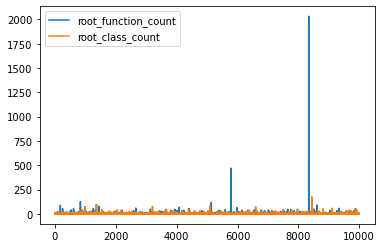

In [30]:
df[['root_function_count', 'root_class_count']].plot()

class_only 4011
func_only 2744
class_func_both 1604


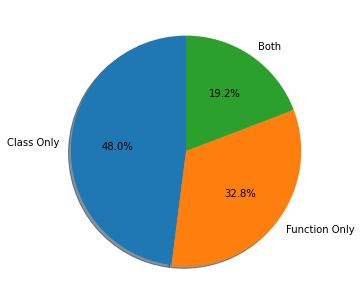

In [36]:
class_only = df[(df['root_class_count'] > 0) & (df['root_function_count'] == 0)]
func_only = df[(df['root_class_count'] == 0) & (df['root_function_count'] > 0)]
class_func_both = df[(df['root_class_count'] > 0) & (df['root_function_count'] > 0)]

print('class_only', len(class_only))
print('func_only', len(func_only))
print('class_func_both', len(class_func_both))

class_func_both_data = [len(class_only), len(func_only), len(class_func_both)]
class_func_both_data_labels = ['Class Only', 'Function Only', 'Both']

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ax.pie(class_func_both_data,labels=class_func_both_data_labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
fig.savefig('pie.png')

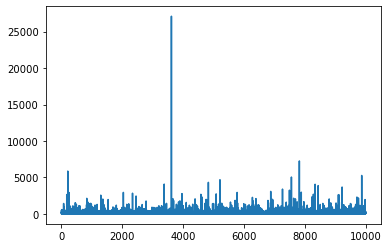

In [32]:
df['non_empty_line_count'].plot()

In [33]:
df.loc[df['non_empty_line_count'].idxmax()]

index                                                                3618
filename                data_openstack_proliantutils_proliantutils_tes...
non_empty_line_count                                                27112
is_init                                                             False
root_class_count                                                        0
root_function_count                                                     0
Name: 3618, dtype: object